In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
def readNumEvents(file):
    """
    Moderately efficent way to get the number of events stored in file.
    """
    
    with pylhe._extract_fileobj(file) as fileobj:
        nevts = sum(element.tag == "event" for event, element in ET.iterparse(fileobj, events=["end"]))
    return nevts

In [3]:
# inputFiles = {'axial_run01': '../DMSimp_axial_parton/Events/run_01/unweighted_events.lhe.gz',
#               'axial_run02': '../DMSimp_axial_parton/Events/run_02/unweighted_events.lhe.gz',
#               'axial_run03': '../DMSimp_axial_parton/Events/run_09/unweighted_events.lhe.gz',
#               'axial_run04': '../DMSimp_axial_parton/Events/run_07/unweighted_events.lhe.gz',
#               'vector_run01': '../DMSimp_vector_parton/Events/run_01/unweighted_events.lhe.gz',
#               'vector_run02': '../DMSimp_vector_parton/Events/run_02/unweighted_events.lhe.gz',
#               'vector_run03': '../DMSimp_vector_parton/Events/run_10/unweighted_events.lhe.gz',
#               'vector_run04': '../DMSimp_vector_parton/Events/run_09/unweighted_events.lhe.gz',
#               'scalar_run01': '../DMSimp_scalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'scalar_run02': '../DMSimp_scalar_parton/Events/run_02/unweighted_events.lhe.gz',
#               'scalar_run03': '../DMSimp_scalar_parton/Events/run_03/unweighted_events.lhe.gz',
#               'scalar_run04': '../DMSimp_scalar_parton/Events/run_04/unweighted_events.lhe.gz',
#               'pseudoscalar_run01': '../DMSimp_pseudoscalar_parton/Events/run_01/unweighted_events.lhe.gz',
#               'pseudoscalar_run02': '../DMSimp_pseudoscalar_parton/Events/run_02/unweighted_events.lhe.gz',
#               'pseudoscalar_run03': '../DMSimp_pseudoscalar_parton/Events/run_03/unweighted_events.lhe.gz',
#               'pseudoscalar_run04': '../DMSimp_pseudoscalar_parton/Events/run_04/unweighted_events.lhe.gz',
#               }

# inputFiles = {'axial_nnlo_01': '../DMSimp_axial_parton/Events/run_17/unweighted_events.lhe.gz',
#               'axial_lo_01': '../DMSimp_axial_parton/Events/run_16/unweighted_events.lhe.gz',
#               'axial_lo_02': '../DMSimp_axial_parton/Events/run_15/unweighted_events.lhe.gz',
#               'axial_nnlo_02': '../DMSimp_axial_parton/Events/run_14/unweighted_events.lhe.gz',
#               'axial_nnlo_03': '../DMSimp_axial_parton/Events/run_13/unweighted_events.lhe.gz'}

inputFiles = {'axial_run03': '../DMSimp_axial_parton/Events/run_10/unweighted_events.lhe.gz',
              'vector_run03': '../DMSimp_vector_parton/Events/run_11/unweighted_events.lhe.gz',
              'axial_run04': '../DMSimp_axial_parton/Events/run_06/unweighted_events.lhe.gz',
              'vector_run04': '../DMSimp_vector_parton/Events/run_06/unweighted_events.lhe.gz',
              'pseudoscalar_run03': '../DMSimp_pseudoscalar_parton/Events/run_03/unweighted_events.lhe.gz',
              'scalar_run03': '../DMSimp_scalar_parton/Events/run_03/unweighted_events.lhe.gz',
              'pseudoscalar_run04': '../DMSimp_pseudoscalar_parton/Events/run_04/unweighted_events.lhe.gz',
              'scalar_run04': '../DMSimp_scalar_parton/Events/run_04/unweighted_events.lhe.gz'
              }

In [4]:
events = {}
nevents = {}
for label,f in inputFiles.items():   
    events[label] = pylhe.read_lhe_with_attributes(f)
    nevents[label] = readNumEvents(f)


In [5]:
parameters = {}
for label,file in inputFiles.items():
    banner = sorted(glob.glob(os.path.dirname(file)+'/*banner.txt'),key=os.path.getmtime,reverse=True)
    if len(banner) == 0:
        print('Banner not found for %s' %label)
    elif len(banner) > 1:        
        print('\n%i banner files found for %s. Using %s' 
              %(len(banner),label,os.path.basename(banner[0])))
    banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    if 55 in pars.blocks['MASS']:
        model = 'spin1'
        mMed = pars.blocks['MASS'][55]
    elif 54 in pars.blocks['MASS']:
        model = 'spin0'
        mMed = pars.blocks['MASS'][54]
        
    mDM = pars.blocks['MASS'][52]
    if model == 'spin1':
        gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
        gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
        gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
        gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    elif model == 'spin0':
        gVq = pars.blocks['DMINPUTS'][6] # Mediator-quark scalar coupling
        gAq = pars.blocks['DMINPUTS'][12] # Mediator-quark pseudoscalar coupling
        gVx = pars.blocks['DMINPUTS'][3] # Mediator-DM scalar coupling
        gAx = pars.blocks['DMINPUTS'][4] # Mediator-DM pseudoscalar coupling
        
        
    parameters[label] = {'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV' %(mMed,mDM))

axial_run03 : mMed = 1000.00 GeV, mDM = 400.00 GeV
vector_run03 : mMed = 1000.00 GeV, mDM = 400.00 GeV
axial_run04 : mMed = 1000.00 GeV, mDM = 600.00 GeV
vector_run04 : mMed = 1000.00 GeV, mDM = 600.00 GeV
pseudoscalar_run03 : mMed = 1000.00 GeV, mDM = 400.00 GeV
scalar_run03 : mMed = 1000.00 GeV, mDM = 400.00 GeV
pseudoscalar_run04 : mMed = 1000.00 GeV, mDM = 600.00 GeV
scalar_run04 : mMed = 1000.00 GeV, mDM = 600.00 GeV


In [6]:
## jets
pTj1min = 25.
pTjmin = 25.
# etamax = 2.4
# ## MET
minMET = 25.
# ## Electrons
# pTmin_el = 10.
# etamax_el = 2.5
# nMax_el = 0
# ## Muons
# pTmin_mu = 10.
# etamax_mu = 2.4
# nMax_mu = 0

In [7]:
## jets
pTj1min = 25.
pTjmin = 25.
etamax = 5;
# ## MET
minMET = 25.
# ## Electrons
# pTmin_el = 10.
# etamax_el = 2.5
# nMax_el = 0
# ## Muons
# pTmin_mu = 10.
# etamax_mu = 2.4
# nMax_mu = 0

In [8]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0 for label in inputFiles}
negweight = {label : np.array([]) for label in inputFiles}

for label,evts in events.items():
   
    nevts = nevents[label]
    parameters[label]['Events'] = nevts
    
    for event in evts:

        particles = event.particles
       
        jets = [p for p in particles if abs(p.id) in [1,2,3,4,5,21] and p.status == 1]
#         med = [p for p in particles if abs(p.id) in [55] and p.status == 1]
        dm = [p for p in particles if abs(p.id) in [52] and p.status == 1]
#         electrons = [p for p in particles if abs(p.id) in [11] and p.status == 1]
#         muons = [p for p in particles if abs(p.id) in [13] and p.status == 1]
        
#         if len(med) != 1:
#             continue
        if len(dm) != 2:
            continue
            
        weight = event.eventinfo.weight/nevts
            
        if weight < 0:
            negw = weight
            negweight[label] += negw
            negweight[label] = np.append(negweight[label], negw)
            continue
            
        totalweight[label] += weight
            
        # Filter jets
        jetList = []
        for j in jets:
            pT = np.sqrt(j.px**2+j.py**2)
            p = np.sqrt(j.px**2+j.py**2+j.pz**2)
            pL = j.pz
            eta = 0.5*np.log((p+pL)/(p-pL))
            
            if pT < pTjmin:
                continue
            if np.abs(eta) > etamax:
                continue
            jetList.append(j)
        jetList = sorted(jetList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)          
        
            
        # Filter electrons
#         electronList = []
#         for el in electrons:
#             pT = np.sqrt(el.px**2+el.py**2)
#             p = np.sqrt(el.px**2+el.py**2+el.pz**2)
#             pL = el.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
# #             if pT < pTmin_el:
# #                 continue
# #             if np.abs(eta) > etamax_el:
# #                 continue
#             electronList.append(el)
#         electronList = sorted(electronList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                    
        
        # Filter muons
#         muonList = []
#         for mu in muons:
#             pT = np.sqrt(mu.px**2+mu.py**2)
#             p = np.sqrt(mu.px**2+mu.py**2+mu.pz**2)
#             pL = mu.pz
#             eta = 0.5*np.log((p+pL)/(p-pL))
            
#             if pT < pTmin_mu:
#                 continue
#             if np.abs(eta) > etamax_mu:
#                 continue
#             muonList.append(mu)
#         muonList = sorted(muonList, key = lambda j: np.sqrt(j.px**2+j.py**2), reverse=True)                                            
              
        # Compute MET
#         MET = np.sqrt((med[0].px)**2 + (med[0].py)**2)
        MET = np.sqrt((dm[0].px+dm[1].px)**2 + (dm[0].py+dm[1].py)**2)
        
        # Compute deltaPhi
#         if len(jetList) > 0:
#             phij1 = np.arctan2(jetList[0].py,jetList[0].px)
# #             phiMET = np.arctan2((med[0].py),(med[0].px))
#             phiMET = np.arctan2((dm[0].py+dm[1].py),(dm[0].px+dm[1].px))
#             deltaPhi = np.abs(phij1-phiMET)
#         else:
#             deltaPhi = 0.0
        
#         #Apply cuts:
#         if len(electronList) > 0:
#             continue
#         if len(muonList) > 0:
#             continue
#         if len(jetList) == 0:
#             continue
        
        pT1 = np.sqrt(jetList[0].px**2+jetList[0].py**2)
        if MET < minMET:
            continue
        if pT1 < pTj1min:
            continue
#         if deltaPhi < 0.5:
#             continue
        
        # Store relevant data        
        njets[label] = np.append(njets[label],len(jets))
        pTj1[label] = np.append(pTj1[label],pT1)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],MET)
        

In [9]:
for label in weights:
    frac = np.array(len(negweight[label]))/nevents[label]*100
    print(label, 'Fraction of negative events: %1.2f%%' 
          %frac)

axial_run03 Fraction of negative events: 0.71%
vector_run03 Fraction of negative events: 0.73%
axial_run04 Fraction of negative events: 2.72%
vector_run04 Fraction of negative events: 1.78%
pseudoscalar_run03 Fraction of negative events: 0.32%
scalar_run03 Fraction of negative events: 0.34%
pseudoscalar_run04 Fraction of negative events: 0.56%
scalar_run04 Fraction of negative events: 0.66%


In [10]:
for label, w in weights.items():
    print(len(weights[label]))

198571
198530
97278
98217
99677
99664
99438
99345


In [11]:
nevents

{'axial_run03': 200000,
 'vector_run03': 200000,
 'axial_run04': 100000,
 'vector_run04': 100000,
 'pseudoscalar_run03': 100000,
 'scalar_run03': 100000,
 'pseudoscalar_run04': 100000,
 'scalar_run04': 100000}

In [12]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb' %w)
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(weights.keys())}    

axial_run03 total cross-section = 1.646e+00 pb
vector_run03 total cross-section = 4.058e+00 pb
axial_run04 total cross-section = 9.421e-03 pb
vector_run04 total cross-section = 4.728e-02 pb
pseudoscalar_run03 total cross-section = 1.810e-02 pb
scalar_run03 total cross-section = 6.926e-03 pb
pseudoscalar_run04 total cross-section = 1.508e-04 pb
scalar_run04 total cross-section = 2.811e-05 pb


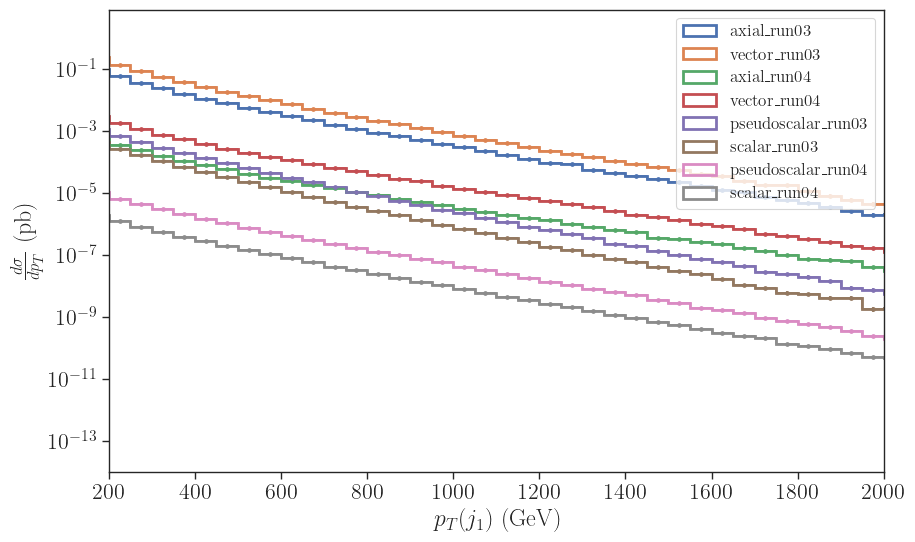

In [13]:
fig = plt.figure(figsize=(10,6))
for label,pt in pTj1.items():
#     if label in ['scalar_run03']:
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2, density=False)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-9,1e-3)
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(200,2000)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

In [14]:
# fig = plt.figure(figsize=(10,6))
# for label,metPts in met.items():
#     if 'run01' in label:
#         binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
#                                         label=r'%s; $m_{DM} $= %1.f GeV' %(label.split('_')[0], parameters[label]['mDM']),
#                                          histtype='step',color=colors[label],
#                                          weights=weights[label],linewidth=2, density=True)
#         errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
#         errorc = np.sqrt(errorc2)
#         binCenter = (binEdges[0:-1]+binEdges[1:])/2.
# #         plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
# #                      drawstyle = 'steps-mid',color=colors[label])
#     if 'run02' in label:
#         binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
#                                          label=r'%s; $m_{DM} $= %1.f GeV' %(label.split('_')[0], parameters[label]['mDM']),
#                                          histtype='step',color=colors[label],
#                                          weights=weights[label],linewidth=2, density=True)
#         errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
#         errorc = np.sqrt(errorc2)
#         binCenter = (binEdges[0:-1]+binEdges[1:])/2.

    
# plt.yscale('log')
# # plt.ylim(1e-8,1)
# plt.xlabel(r'$p_T^{miss}$ (GeV)')
# plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
# plt.xlim(0,1500)
# plt.legend(loc='lower left', fontsize='xx-small')
# plt.title(r'Missing energy distribution for $m_{med} = 500$ GeV')
# plt.show()

In [15]:
# fig = plt.figure(figsize=(10,6))
# for label,metPts in met.items():
#     if 'run04' in label:
#         binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
#                                    label=label,histtype='step',color=colors[label],
#                                    weights=weights[label],linewidth=2,density=True)
# #         errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
# #         errorc = np.sqrt(errorc2)
# #         binCenter = (binEdges[0:-1]+binEdges[1:])/2.
# #         plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
# #                      drawstyle = 'steps-mid',color=colors[label])

    
# plt.yscale('log')
# # plt.ylim(1e-3,1)
# plt.xlabel(r'$p_T^{miss}$ (GeV)')
# plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
# plt.xlim(0,2000)
# plt.legend(loc='upper right', fontsize='x-small')
# plt.show()

/tmp/ipykernel_24041/3762056230.py:32: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/3762056230.py:32: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/3762056230.py:33: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs


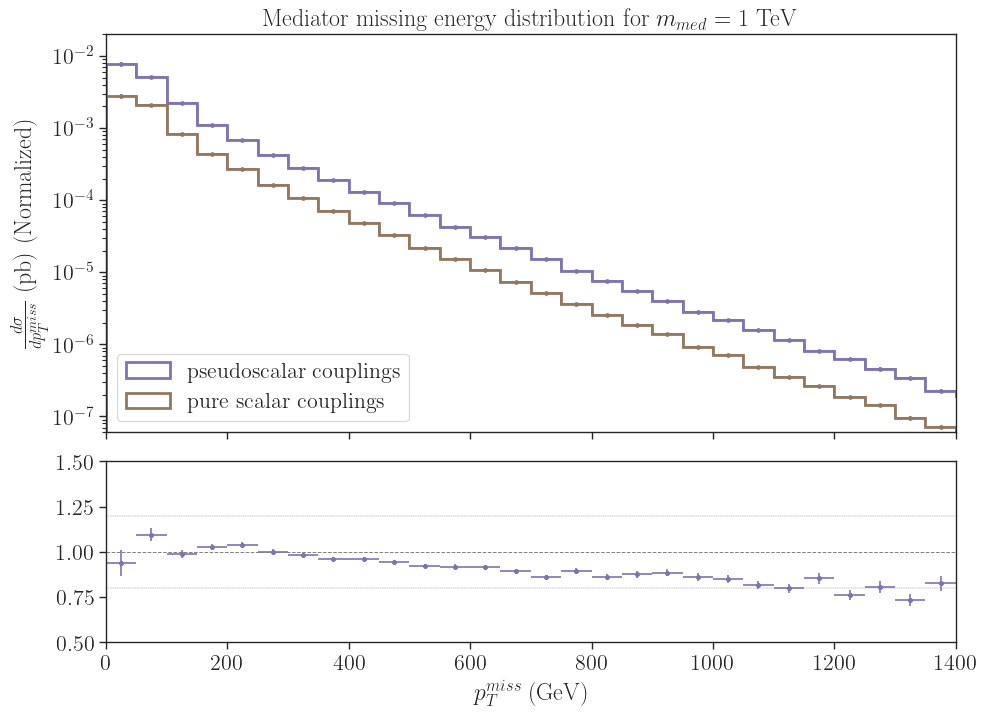

In [16]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

# k=1
k = totalweight['pseudoscalar_run03']/totalweight['scalar_run03']

for label,metPts in met.items():
    if label in ['scalar_run03']:
        bincSc,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
        errorSc2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorSc = np.sqrt(errorSc2)
        errorSc[errorSc<0] = 0
        ax[0].errorbar(binCenter,bincSc,yerr = errorSc, marker = '.', drawstyle = 'steps-mid',color=colors[label])

    
    if label in ['pseudoscalar_run03']:
        bincPs,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'%s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2)
        errorPs2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorPs = np.sqrt(errorPs2)
        errorPs[errorPs<0] = 0
        
        ax[0].errorbar(binCenter,bincPs,yerr = errorPs, marker = '.', drawstyle = 'steps-mid',color=colors[label])

        
ratio = k*bincSc/bincPs
ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs
binCenter = (binEdges[0:-1]+binEdges[1:])/2.
errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[1].scatter(binCenter, ratio, marker='.')
ax[1].errorbar(binCenter,ratio,xerr = errorh, yerr = ratioErr, fmt='.', color=colors['pseudoscalar_run03'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)

        
ax[0].set_yscale('log')
ax[0].set_ylim(6e-8,2e-2)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)')
ax[0].set_xlim(0,1400)
ax[0].legend(loc='lower left')
ax[0].set_title(r'Mediator missing energy distribution for $m_{med} = 1$ TeV')


ax[1].set_ylim(0.5,1.5)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)')

# plt.savefig('plot-s-ps-bias.png')
plt.show()

/tmp/ipykernel_24041/2993489360.py:28: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/2993489360.py:28: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/2993489360.py:29: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs


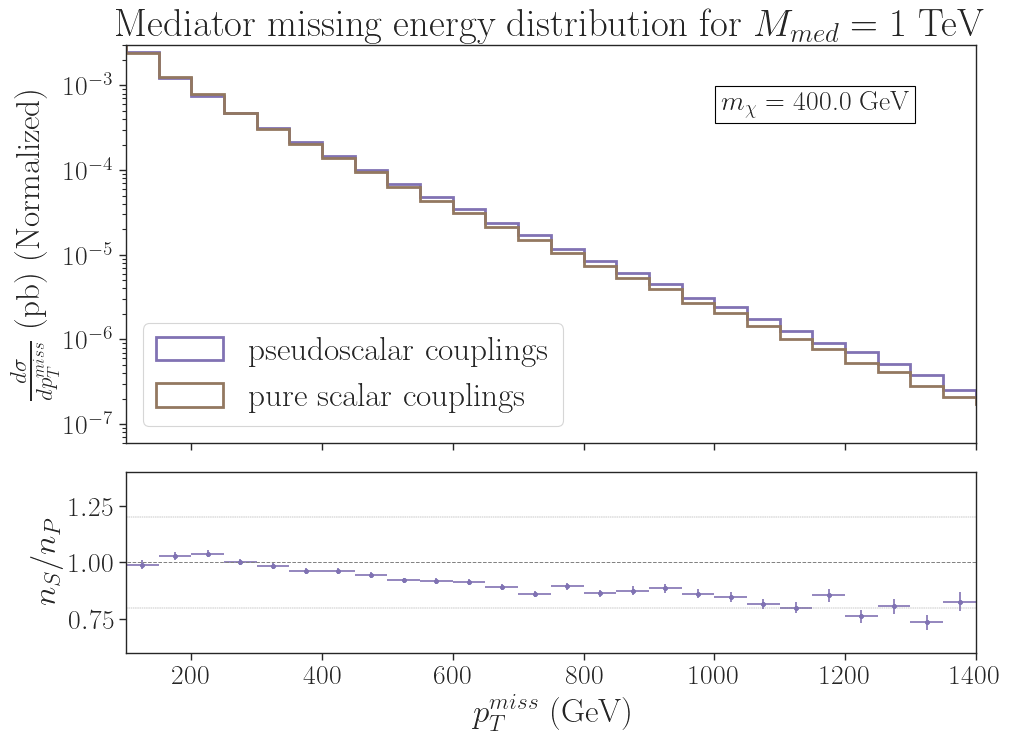

In [17]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

k = totalweight['pseudoscalar_run03']/totalweight['scalar_run03']

for label,metPts in met.items():
    if label in ['scalar_run03']:
        bincScNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincSc, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorSc2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorSc = np.sqrt(errorSc2)

    
    if label in ['pseudoscalar_run03']:
        bincPsNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'%s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincPs, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorPs2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorPs = np.sqrt(errorPs2)

        

ratio = k*bincSc/bincPs
ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs
errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[1].scatter(binCenter, ratio, marker='.')
ax[1].errorbar(binCenter,ratio,xerr = errorh, yerr = ratioErr, fmt='.', color=colors['pseudoscalar_run03'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)

        
ax[0].set_yscale('log')
ax[0].set_ylim(6e-8,3e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(100,1400)
ax[0].legend(loc='lower left', fontsize=24)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)

ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['scalar_run03']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)


ax[1].set_xlim(100,1400)
ax[1].set_ylim(.6,1.4)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{S}/n_{P}$', fontsize=24)


plt.savefig('plot-s-ps-bias-mdm400.png')
plt.show()

/tmp/ipykernel_24041/2832224877.py:27: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/2832224877.py:27: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincSc/bincPs
/tmp/ipykernel_24041/2832224877.py:28: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs


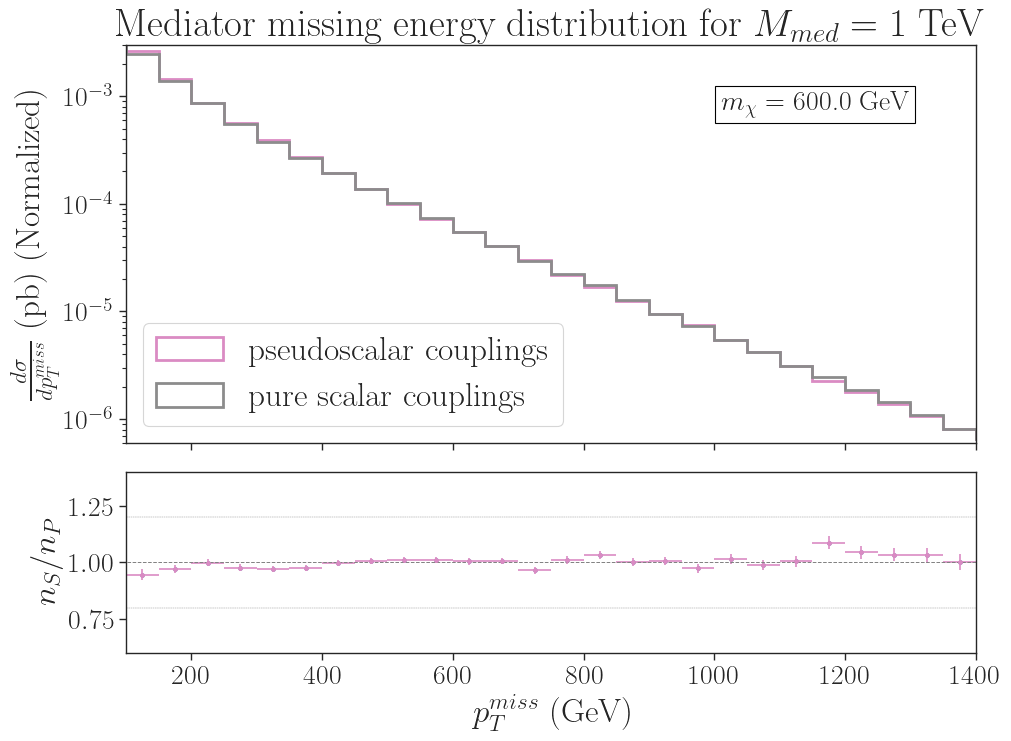

In [18]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

k = totalweight['pseudoscalar_run04']/totalweight['scalar_run04']

for label,metPts in met.items():
    if label in ['scalar_run04']:
        bincScNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincSc, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorSc2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorSc = np.sqrt(errorSc2)

    
    if label in ['pseudoscalar_run04']:
        bincPsNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'%s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincPs, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorPs2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorPs = np.sqrt(errorPs2)

        
ratio = k*bincSc/bincPs
ratioErr = np.sqrt(errorSc**2 + ratio**2 * errorPs**2)/bincPs
binCenter = (binEdges[0:-1]+binEdges[1:])/2.
errorh = (np.diff(binEdges+[2000.])/2).tolist()

ax[1].scatter(binCenter, ratio, marker='.')
ax[1].errorbar(binCenter,ratio,xerr=errorh, yerr=ratioErr, fmt='.', color=colors['pseudoscalar_run04'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)


ax[0].set_yscale('log')
ax[0].set_ylim(6e-7,3e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(100,1400)
ax[0].legend(loc='lower left', fontsize=24)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)

ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['scalar_run04']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)


ax[1].set_xlim(100,1400)
ax[1].set_ylim(.6,1.4)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{S}/n_{P}$', fontsize=24)


plt.savefig('plot-s-ps-bias-mdm600.png')
plt.show()

/tmp/ipykernel_24041/2459977636.py:28: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincAx/bincVec
/tmp/ipykernel_24041/2459977636.py:28: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincAx/bincVec
/tmp/ipykernel_24041/2459977636.py:29: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorAx**2 + ratio**2 * errorVec**2)/bincVec


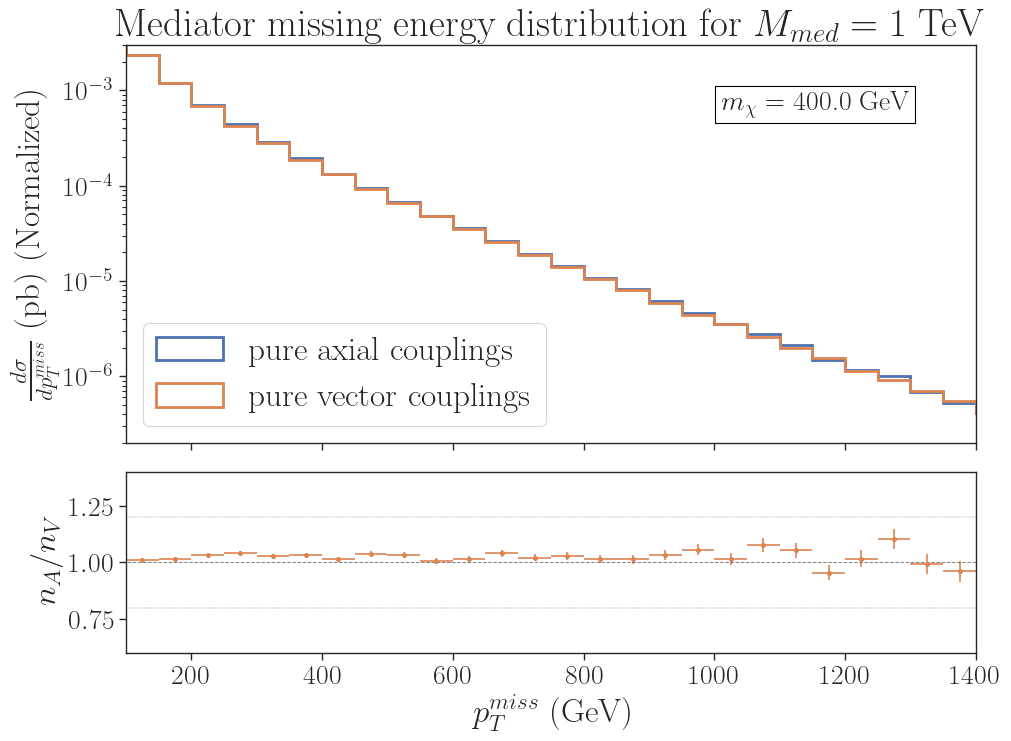

In [19]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

k = totalweight['vector_run03']/totalweight['axial_run03']

for label,metPts in met.items():
    if label in ['axial_run03']:
        bincAxNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        
        bincAx, _ = np.histogram(metPts,bins=binEdges,weights=weights[label], density=False)
        errorAx2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2, density=False)
        errorAx = np.sqrt(errorAx2)
        
    elif label in ['vector_run03']:
        bincVecNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        
        bincVec, _ = np.histogram(metPts,bins=binEdges,weights=weights[label], density=False)
        errorVec2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2, density=False)
        errorVec = np.sqrt(errorVec2)
        
        
ratio = k*bincAx/bincVec
ratioErr = np.sqrt(errorAx**2 + ratio**2 * errorVec**2)/bincVec

binCenter = (binEdges[0:-1]+binEdges[1:])/2.
errorh = (np.diff(binEdges+[2000.])/2).tolist()    

ax[1].scatter(binCenter, ratio, marker='.', color=colors['vector_run03'])
ax[1].errorbar(binCenter,ratio, xerr = errorh, yerr=ratioErr, fmt='.', color=colors['vector_run03'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
        

ax[0].set_yscale('log')
ax[0].set_ylim(2e-7,3e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(100,1400)
ax[0].legend(loc='lower left', fontsize=24)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)

ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['axial_run03']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)

ax[1].set_xlim(100,1400)
ax[1].set_ylim(.6,1.4)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{A}/n_{V}$', fontsize=24)

plt.savefig('plot-v-av-mxd400.png')
plt.show()

/tmp/ipykernel_24041/509564751.py:28: RuntimeWarning: divide by zero encountered in divide
  ratio = k*bincAx/bincVec
/tmp/ipykernel_24041/509564751.py:28: RuntimeWarning: invalid value encountered in divide
  ratio = k*bincAx/bincVec
/tmp/ipykernel_24041/509564751.py:29: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorAx**2 + ratio**2 * errorVec**2)/bincVec


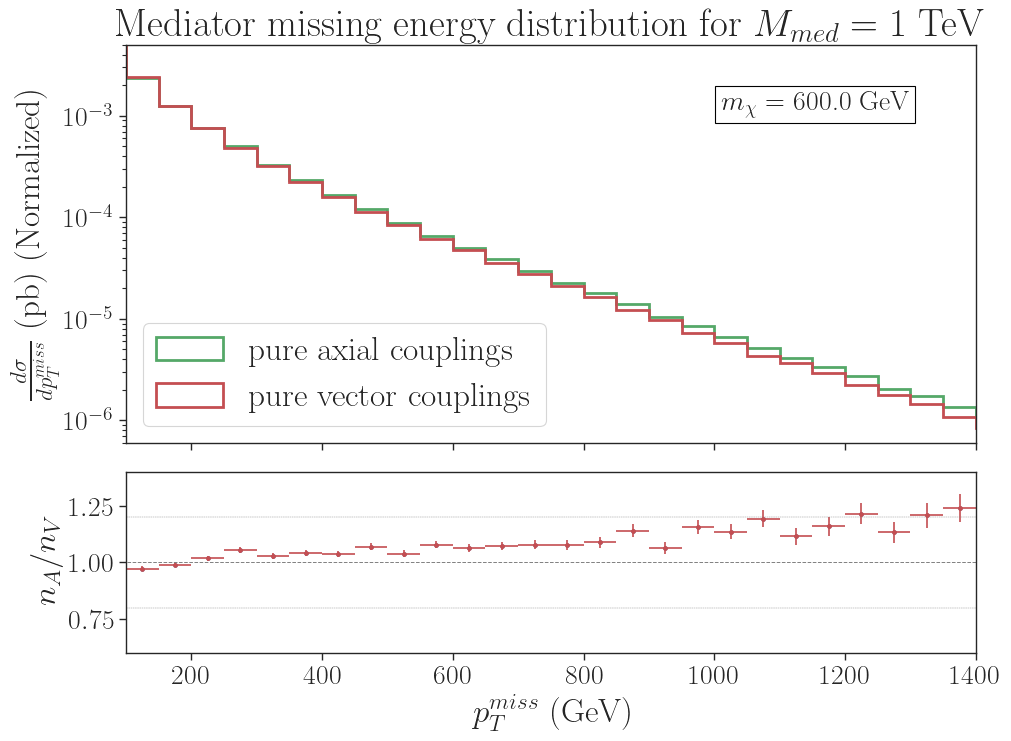

In [20]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

k = totalweight['vector_run04']/totalweight['axial_run04']


for label,metPts in met.items():
    if label in ['axial_run04']:
        bincAxNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincAx, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorAx2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorAx = np.sqrt(errorAx2)
        
    elif label in ['vector_run04']:
        bincVecNorm,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        bincVec, _ = np.histogram(metPts,bins=binEdges,weights=weights[label])
        errorVec2, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        errorVec = np.sqrt(errorVec2)
    
        
        
ratio = k*bincAx/bincVec
ratioErr = np.sqrt(errorAx**2 + ratio**2 * errorVec**2)/bincVec
binCenter = (binEdges[0:-1]+binEdges[1:])/2.
errorh = (np.diff(binEdges+[2000.])/2).tolist()    

ax[1].scatter(binCenter, ratio, marker='.')
ax[1].errorbar(binCenter,ratio, xerr = errorh, yerr=ratioErr, fmt='.', color=colors['vector_run04'])
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
        

ax[0].set_yscale('log')
ax[0].set_ylim(6e-7,5e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(100,1400)
ax[0].legend(loc='lower left', fontsize=24)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)

ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['axial_run04']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)

ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)

ax[1].set_xlim(100,1400)
ax[1].set_ylim(.6,1.4)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{A}/n_{V}$', fontsize=24)


plt.savefig('plot-v-av-mxd600.png')
plt.show()

/tmp/ipykernel_24041/3722714540.py:23: RuntimeWarning: divide by zero encountered in divide
  ratio = bincS1/binc
/tmp/ipykernel_24041/3722714540.py:23: RuntimeWarning: invalid value encountered in divide
  ratio = bincS1/binc
/tmp/ipykernel_24041/3722714540.py:24: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorS1**2 + ratio**2 * errorL**2)/binc


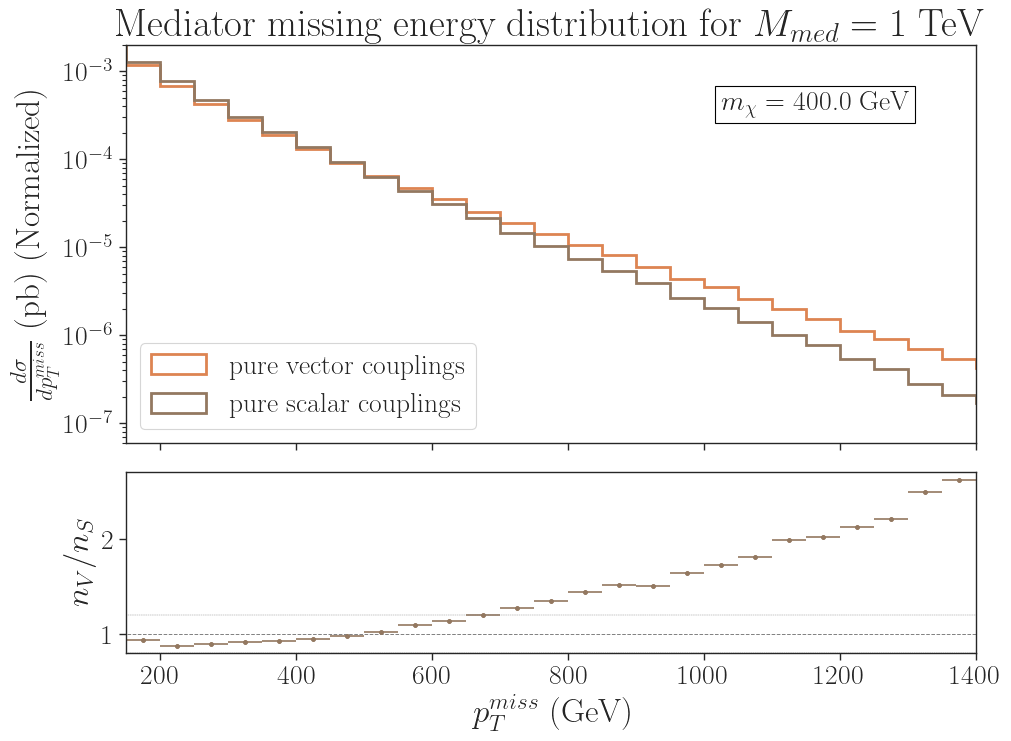

In [21]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
    if label in ['vector_run03']:
        bincS1,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        errorS1, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        
for label,metPts in met.items():
    if label in ['scalar_run03']:
        binc,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
        errorh = (np.diff(binEdges+[2000.])/2).tolist()
        errorL, _ =  np.histogram(metPts,bins=binEdges,weights=weights[label]**2) 
        
        ratio = bincS1/binc
        ratioErr = np.sqrt(errorS1**2 + ratio**2 * errorL**2)/binc

        ax[1].scatter(binCenter, ratio, marker='.', label=r'%s couplings' %(label.split('_')[0]),
                      color=colors[label])
        ax[1].errorbar(binCenter,ratio, xerr=errorh, yerr=ratioErr, fmt='.', color=colors[label])
        
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
  
ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['scalar_run03']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)
ax[0].set_yscale('log')
ax[0].set_ylim(6e-8,2e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(150,1400)
ax[0].legend(loc='lower left', fontsize=20)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)
ax[0].tick_params(labelsize=20)


ax[1].tick_params(labelsize=20)
ax[1].set_ylim(0.8,2.7)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{V}/n_{S}$', fontsize=24)

plt.savefig('plot-s-ps-v-av-mxd400.png')
plt.show()

/tmp/ipykernel_24041/3779536565.py:23: RuntimeWarning: divide by zero encountered in divide
  ratio = bincS1/binc
/tmp/ipykernel_24041/3779536565.py:23: RuntimeWarning: invalid value encountered in divide
  ratio = bincS1/binc
/tmp/ipykernel_24041/3779536565.py:24: RuntimeWarning: invalid value encountered in multiply
  ratioErr = np.sqrt(errorS1**2 + ratio**2 * errorL**2)/binc


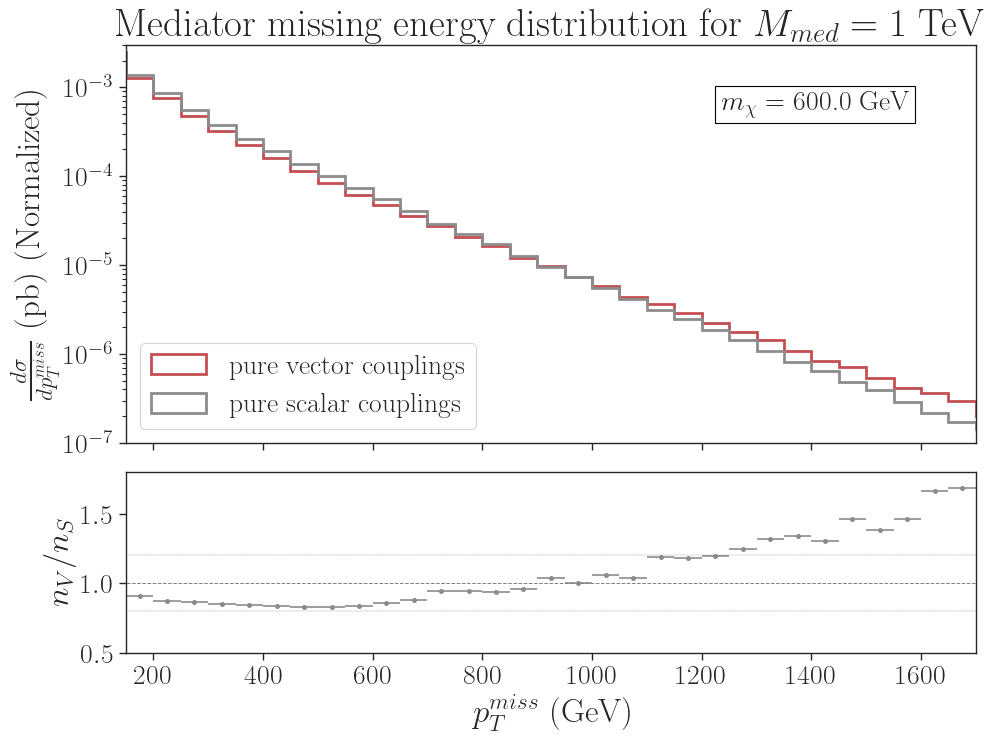

In [22]:
figs, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2.2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
    if label in ['vector_run04']:
        bincS1,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        errorS1, _ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
        
for label,metPts in met.items():
    if label in ['scalar_run04']:
        k = totalweight['vector_run04']/totalweight[label]
        binc,binEdges,patches = ax[0].hist(metPts,bins=np.linspace(0,5000,101),
                                        label=r'pure %s couplings' %(label.split('_')[0]),
                                         histtype='step',color=colors[label],
                                         weights=weights[label],linewidth=2, density=True)
        binCenter = (binEdges[0:-1]+binEdges[1:])/2.
        errorh = (np.diff(binEdges+[2000.])/2).tolist()
        errorL, _ =  np.histogram(metPts,bins=binEdges,weights=weights[label]**2) 
        
        ratio = bincS1/binc
        ratioErr = np.sqrt(errorS1**2 + ratio**2 * errorL**2)/binc


        ax[1].scatter(binCenter, ratio, marker='.', label=r'%s couplings' %(label.split('_')[0]),
                      color=colors[label])
        ax[1].errorbar(binCenter,ratio, xerr=errorh, yerr = ratioErr, fmt='.', color=colors[label])

        
    
        
ax[0].text(0.7,3,r'$m_{\chi} =$ %.1f GeV' %parameters['scalar_run04']['mDM'],
           fontsize=20,bbox=dict(facecolor='none', edgecolor='black'),transform = plt.gca().transAxes)
ax[1].hlines(y=1, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.7)
ax[1].hlines(y=1.2, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
ax[1].hlines(y=0.8, xmin=0, xmax=2000., linestyle='--', color='gray', linewidth=0.3)
    
ax[0].set_yscale('log')
ax[0].set_ylim(1e-7,3e-3)
ax[0].set_ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb) (Normalized)', fontsize=24)
ax[0].set_xlim(150,1700)
ax[0].legend(loc='lower left', fontsize=20)
ax[0].set_title(r'Mediator missing energy distribution for $M_{med} = 1$ TeV', fontsize=28)
ax[0].tick_params(labelsize=20)


ax[1].tick_params(labelsize=20)
ax[1].set_ylim(0.5,1.8)
ax[1].set_xlabel(r'$p_T^{miss}$ (GeV)', fontsize=24)
ax[1].set_ylabel(r'$n_{V}/n_{S}$', fontsize=24)

plt.savefig('plot-s-ps-v-av-mxd600.png')
plt.show()

In [23]:
ratioErr

array([2.75031171e-05, 6.18180728e-06, 1.93274017e-06, 8.68645885e-07,
       4.95844049e-07, 3.27708967e-07, 2.27724688e-07, 1.69658040e-07,
       1.30544544e-07, 1.03147759e-07, 8.46770934e-08, 7.10531165e-08,
       6.16712741e-08, 5.42753233e-08, 5.02493418e-08, 4.41335534e-08,
       3.85199882e-08, 3.51750676e-08, 3.38878753e-08, 2.95943046e-08,
       2.81988394e-08, 2.51052917e-08, 2.62150654e-08, 2.39386362e-08,
       2.23642630e-08, 2.13840125e-08, 2.09629354e-08, 1.98039259e-08,
       1.78706822e-08, 1.88183626e-08, 1.66440708e-08, 1.64828066e-08,
       1.76279353e-08, 1.68168720e-08, 1.32200798e-08, 1.60411681e-08,
       1.41908551e-08, 1.38921760e-08, 1.25068607e-08, 1.37231823e-08,
       1.11534951e-08, 1.20713292e-08, 1.02771378e-08, 1.82055352e-08,
       7.83635578e-09, 7.24586807e-09, 1.13214288e-08, 1.43201630e-08,
       1.36966192e-08, 9.37134401e-09, 5.67803146e-09, 5.09716825e-09,
       1.86489380e-08, 9.13969747e-09, 2.12114808e-08, 2.22895904e-09,
      

In [24]:

# inputFiles = {'axial_nnlo_01': '../DMSimp_axial_parton/Events/run_17/unweighted_events.lhe.gz',
#               'axial_lo_01': '../DMSimp_axial_parton/Events/run_16/unweighted_events.lhe.gz',
#               'axial_lo_02': '../DMSimp_axial_parton/Events/run_15/unweighted_events.lhe.gz',
#               'axial_nnlo_02': '../DMSimp_axial_parton/Events/run_14/unweighted_events.lhe.gz',
#               'axial_nnlo_03': 